<h1 style="text-align: center;">Reinforcement Learning</h1>
<h3 style="text-align: center;">Temporal Difference Learning</h3>
<h4 style="text-align: center;">Jacques Simon VELLIN</h4>

*This notebook explores the various aspects of TD and LSTD methods in a simple MDP (queueing system). The goal is to approximate the best strategy for reducing queue lengths while minimizing costs using `sample-based learning methods`, starting from a full queue.*

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

# 0) Context

**Reward Function ($r$)** → Score received at each step. It **penalizes** both a long queue and the cost of using a faster strategy. In our case, it behaves more like a cost function:

  $$ r(x, a) = -\left(\frac{x}{N}\right)^2 - c(a) $$

**Value Function ($V^\pi(x)$)** → The **expected total reward** if we follow a certain (fixed) strategy (policy $\pi$) starting from state $x$

  $$ V^\pi(x) = {E}\left[\sum_{t=0}^\infty \gamma^t r(x_t, a_t) \mid x_0 = x, \pi\right] $$

  - **Discount Factor ($\gamma = 0.9$)** → Reduces the weight of future rewards. This avoids infinite sums and reflects the idea that immediate rewards are more valuable than distant ones.

**Transition Mechanics** (How the queue evolves) → probabilities used by comparing them to random numbers between 0 and 1 — if the number is below the threshold, the event (arrival or service) happens.

  - **Arrival Rate ($p = 0.5$)** → With 50% chance, a person **arrives** at each step ().
  - **Service Rate ($q(a)$)** → The chance that a person is **served and leaves** depends on the chosen action: Lazy: $q = 0.51$ (free, but slow) v.s. Aggressive: $q = 0.6$ (faster, but costs 0.01)

**Truncation** → Keeps the queue within the valid range $[0, 99]$, which means that if a step would take us to $-1$ or $100$, we clip it to stay in bounds.

**TD(0)** → Learns value functions step-by-step by guessing-adjusting after seeing what actually happens at each step, updating estimate for a state using just the next state.
  - The **step-size** controls how fast we adapt — too fast and learning is unstable; too slow and it never improves.

**LSTD (Least Squares TD)** → It waits to collect lots of samples, then computes the best value function **in one go** using linear algebra. It's more stable and accurate but needs more memory and computation.

# 1) Setup

## a. MDP Parameters

In [5]:
N = 100         # State space size
p = 0.5         # Arrival rate
q_low = 0.51    # Low service rate
q_high = 0.6    # High service rate
c_low = 0.0     # Cost of low service
c_high = 0.01   # Cost of high service
gamma = 0.9     # Discount factor

In [6]:
def reward(x, a):
    cost = c_low if a == 0 else c_high
    return -(x / N) ** 2 - cost

## b. Fixed Policies

I will need those policies in Problem 1.

In [7]:
def create_policy_lazy():
    """
    Returns a deterministic policy matrix pi[x, a] that always selects a_low (action 0) for all states.
    """
    pi = np.zeros((N, 2))
    pi[:, 0] = 1.0  # Always choose a_low
    return pi

def create_policy_aggressive():
    """
    Returns a piecewise deterministic policy pi[x, a] that chooses a_low for x < 50 and a_high for x >= 50.
    """
    pi = np.zeros((N, 2))
    for x in range(N):
        if x < 50:
            pi[x, 0] = 1.0  # a_low for x < 50
        else:
            pi[x, 1] = 1.0  # a_high for x >= 50
    return pi

## c. Feature Maps

This is the core exploration of this notebook. We want to test different way to encode one of the information used by the learning method during its progress $\to$ the queu lengh.

**Feature Vector ($\phi(x)$)** → A numerical representation of the current queue length wjere different feature maps define how precise or simplified this description is:

- `fine_feature_map` returns an N-dimensional feature vector where $\phi_i(x) = 1$ if $x = i$, else 0, allowing exact representation of all functions on the state space.

- `coarse_feature_map` returns an N/5-dimensional feature vector (simplifying the state) where $\phi_i(x) = 1$ if $x$ is in $[5(i-1), 5i-1]$, representing piecewise constant functions (i.e. groups the queue into blocks of 5).

- `pwl_feature_map` returns a 2*(N/5)-dimensional feature vector, combining coarse features with linear components $\phi_{N/5+i}(x) = 1\{x \in [5(i-1), 5i-1]\} \cdot (x - 5(i-1))/5$, representing piecewise linear functions.

In [ ]:
def fine_feature_map(x):
    """
    Fine feature map: N-dimensional vector, phi_i(x) = 1 if x == i, else 0.
    """
    phi = np.zeros(N)
    phi[x] = 1
    return phi

def coarse_feature_map(x):
    """
    Coarse feature map: (N/5)-dimensional vector, phi_i(x) = 1 if x in [5(i-1), 5i-1].
    """
    phi = np.zeros(N // 5)
    i = x // 5  # Integer division to find the interval
    phi[i] = 1
    return phi

def pwl_feature_map(x):
    """
    Piecewise linear feature map: 2*(N/5)-dimensional vector.
    First N/5 entries: same as coarse feature map.
    Next N/5 entries: phi_(N/5+i)(x) = 1{x in [5(i-1), 5i-1]} * (x - 5(i-1)) / 5.
    """
    phi_coarse = coarse_feature_map(x)
    phi_linear = np.zeros(N // 5)
    i = x // 5
    phi_linear[i] = (x - 5 * i) / 5  # Linear component
    return np.concatenate([phi_coarse, phi_linear])

## d. Utilities

Transition probabilities:

In [8]:
def get_transitions():
    """
    Creates an array P[x, x', a] for transition probabilities.
    """
    P = np.zeros((N, N, 2))  # P[x, x', a]
    for x in range(N):
        for a in range(2):
            q = q_low if a == 0 else q_high
            prob_stay = p * q + (1 - p) * (1 - q)  # I=1,S=1 or I=0,S=0
            prob_up = p * (1 - q)  # I=1,S=0
            prob_down = (1 - p) * q  # I=0,S=1
            if x == 0:
                P[x, x, a] = prob_stay + prob_down
                P[x, x + 1, a] = prob_up
            elif x == N - 1:
                P[x, x - 1, a] = prob_down
                P[x, x, a] = prob_stay + prob_up
            else:
                P[x, x - 1, a] = prob_down
                P[x, x, a] = prob_stay
                P[x, x + 1, a] = prob_up
    return P

def trans(P, pi):
    """
    Computes the state transition matrix P_pi[x, x'] under policy pi.
    """
    X = P.shape[0]
    P_pi = np.zeros((X, X))
    for x in range(X):
        for y in range(X):
            for a in range(2):
                P_pi[x, y] += P[x, y, a] * pi[x, a]
    return P_pi

Policy Evaluation (Iterative):

In [9]:
def evaluate(P, pi, gamma, max_iter=1000, tol=1e-6):
    """
    Performs iterative policy evaluation to compute V^pi.
    """
    X = P.shape[0]
    V = np.zeros(X)
    P_pi = trans(P, pi)
    for _ in range(max_iter):
        V_new = np.zeros(X)
        for x in range(X):
            a = np.argmax(pi[x])  # Deterministic policy
            V_new[x] = reward(x, a) + gamma * np.sum(P_pi[x, :] * V)
        if np.max(np.abs(V_new - V)) < tol:
            break
        V = V_new
    return V


Compute True Value Functions of Fixed Policies:

In [10]:
P = get_transitions()
r = np.array([reward(x, 0) for x in range(N)])  # Reward for a_low (adjusted per policy)
pi_lazy = create_policy_lazy()
pi_aggr = create_policy_aggressive()
V_lazy = evaluate(P, pi_lazy, gamma)
V_aggr = evaluate(P, pi_aggr, gamma)

## e. Compute Optimal Value Function (Dynamic Programming)

To evaluate the quality of the subquent learned policies, I will need the optimal policy as a benchmark. As such, we use policy iteration to do so.

In [11]:
def policy_iteration(P, gamma, max_iter=100, tol=1e-6):
    """
    Parameters:
    P (np.ndarray): Transition probabilities P[x, x', a]
    gamma (float): Discount factor
    max_iter (int): Maximum iterations for policy evaluation
    tol (float): Tolerance for convergence
    
    Returns:
    V_opt (np.ndarray): Optimal value function V*
    pi_opt (np.ndarray): Optimal policy pi*
    """
    # Initialize with lazy policy
    pi = np.zeros((N, 2))
    pi[:, 0] = 1.0 
    
    while True:
        # Policy Evaluation
        V = evaluate(P, pi, gamma=gamma, max_iter=max_iter, tol=tol)
        
        # Policy Improvement
        new_pi = np.zeros((N, 2))
        policy_stable = True
        for x in range(N):
            Q = np.zeros(2)  # Q(x, a) for a_low and a_high
            for a in range(2):
                q = q_low if a == 0 else q_high
                Q[a] = reward(x, a)
                if x == 0:
                    Q[a] += gamma * (1 - p) * ((1 - q) * V[x] + q * V[x])  # x-1 not possible
                    Q[a] += gamma * p * ((1 - q) * V[x + 1] + q * V[x])
                elif x == N - 1:
                    Q[a] += gamma * (1 - p) * ((1 - q) * V[x] + q * V[x - 1])
                    Q[a] += gamma * p * ((1 - q) * V[x] + q * V[x])  # x+1 not possible
                else:
                    Q[a] += gamma * (1 - p) * ((1 - q) * V[x] + q * V[x - 1])
                    Q[a] += gamma * p * ((1 - q) * V[x + 1] + q * V[x])
            best_a = np.argmax(Q)
            new_pi[x, best_a] = 1.0
            if np.argmax(pi[x]) != best_a:
                policy_stable = False
        pi = new_pi
        
        # Check for convergence
        if policy_stable:
            break
    
    return V, pi

In [12]:
# Compute Optimal Value Function
V_opt, pi_opt = policy_iteration(P, gamma)

# Correct name
V_exact_dp = V_opt 
pi_exact_dp = pi_opt

# 2) Compare Evaluation Methods - TD(0) v.s LSTD

In this section, we evaluate how well different learning algorithms approximate the true value function ($V^\pi$) of fixed policies (lazy and aggressive):

- We compare the simplest form of Temporal Difference learning, **[TD(0)]**, against the **Least-Squares TD [LSTD]** method
- We use various **feature encodings** strategy
assess the effect of sample size and representation on the quality of value estimation.

## a. Implementation

`sample_transitions` simulates experience by generating a sequence of transitions from the MDP, following a given policy and starting from an initial state:

In [70]:
def sample_transitions(policy, num_samples, initial_state=N-1):
    """
    Sample transitions (state, action, reward, next_state) following the policy.
    """
    transitions = []
    state = initial_state
    for _ in range(num_samples):
        action = 0 if np.argmax(policy[state]) == 0 else 1  # 0: a_low, 1: a_high
        q = q_low if action == 0 else q_high
        # Sample I_t (arrival) and S_t (service)
        I_t = 1 if np.random.rand() < p else 0
        S_t = 1 if np.random.rand() < q else 0
        next_state = max(0, min(N-1, state + I_t - S_t))  # Apply trunc
        r = reward(state, action)
        transitions.append((state, action, r, next_state))
        state = next_state
    return transitions

In [71]:
def td_zero(transitions, feature_map, dim):
    """
    TD(0) to approximate the value function V^pi using the given feature map.
    """
    theta = np.zeros(dim)  # Parameter vector
    a, b = 10**5, 10**5  # Step-size parameters
    for t, (state, _, r, next_state) in enumerate(transitions):
        alpha_t = a / (t + b)
        phi_x = feature_map(state)
        phi_next = feature_map(next_state)
        td_target = r + gamma * np.dot(theta, phi_next)
        td_error = td_target - np.dot(theta, phi_x)
        theta += alpha_t * td_error * phi_x
    return theta

def lstd(transitions, feature_map, dim, sigma=1e-10):
    """
    LSTD to approximate the value function V^pi using the given feature map.
    
    Parameters:
    transitions (list): List of (state, action, reward, next_state) tuples
    feature_map (callable): Feature map function
    dim (int): Dimensionality of the feature map
    sigma (float): Regularization parameter for matrix inversion
    
    Returns:
    theta (np.ndarray): Parameter vector
    """
    A = np.zeros((dim, dim))
    b = np.zeros(dim)
    for state, _, r, next_state in transitions:
        phi_x = feature_map(state)
        phi_next = feature_map(next_state)
        A += np.outer(phi_x, phi_x - gamma * phi_next)
        b += phi_x * r
    # Regularized inverse to handle potential singularity
    theta = np.linalg.solve(A + sigma * np.eye(dim), b)
    return theta

Compute Value Function from Theta:

In [72]:
def compute_value_function(theta, feature_map):
    """
    Compute V(x) = theta * phi(x) for all states x.
    """
    V = np.zeros(N)
    for x in range(N):
        phi_x = feature_map(x)
        V[x] = np.dot(theta, phi_x)
    return V

## b. Execution

In [ ]:
sample_sizes = [10**4, 10**5, 10**6, 10**7]
feature_maps = [
    ('Fine', fine_feature_map, N),
    ('Coarse', coarse_feature_map, N // 5),
    ('Piecewise Linear', pwl_feature_map, 2 * (N // 5))
]
policies = [('Lazy', pi_lazy), ('Aggressive', pi_aggr)]

# Store results for plots
results = {}

for policy_name, policy in policies:
    results[policy_name] = {}
    transitions = {}
    for size in sample_sizes:
        sampled_transitions = sample_transitions(policy, size)
        transitions[size] = sampled_transitions
    for fm_name, fm, dim in feature_maps:
        results[policy_name][fm_name] = {'TD(0)': {}, 'LSTD': {}}
        for size in sample_sizes:
            
            # TD(0)
            theta_td = td_zero(transitions[size], fm, dim)
            V_td = compute_value_function(theta_td, fm)
            results[policy_name][fm_name]['TD(0)'][size] = V_td
            
            # LSTD
            theta_lstd = lstd(transitions[size], fm, dim)
            V_lstd = compute_value_function(theta_lstd, fm)
            results[policy_name][fm_name]['LSTD'][size] = V_lstd

## c. Plotting

<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:20: SyntaxWarning: invalid escape sequence '\p'
/var/folders/g4/x55k_72x38zgfktpn2kkcg6m0000gn/T/ipykernel_32760/1578290890.py:7: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(range(N), V_true, label='True $V^{\pi}$', color='black', linewidth=2)
/var/folders/g4/x55k_72x38zgfktpn2kkcg6m0000gn/T/ipykernel_32760/1578290890.py:20: SyntaxWarning: invalid escape sequence '\p'
  plt.plot(range(N), V_true, label='True $V^{\pi}$', color='black', linewidth=2)


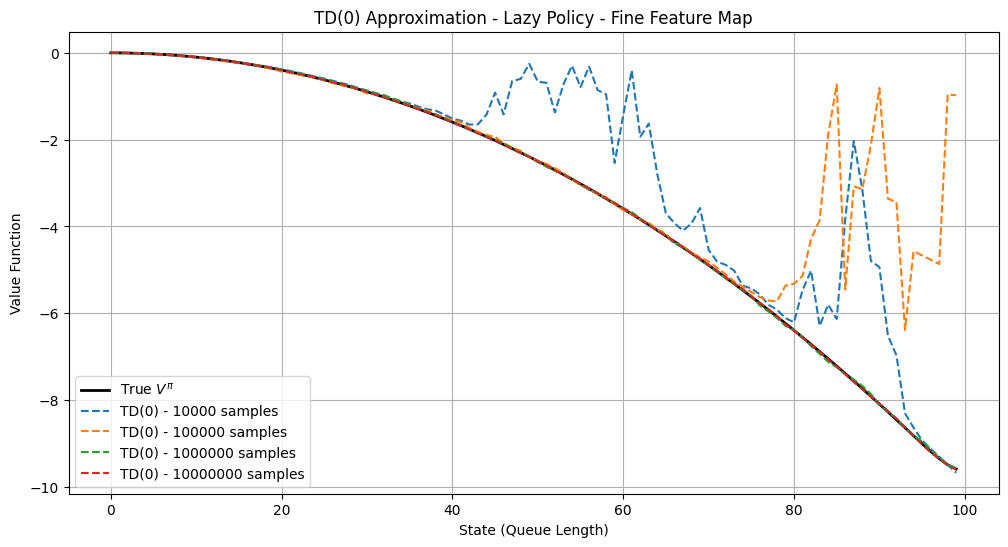

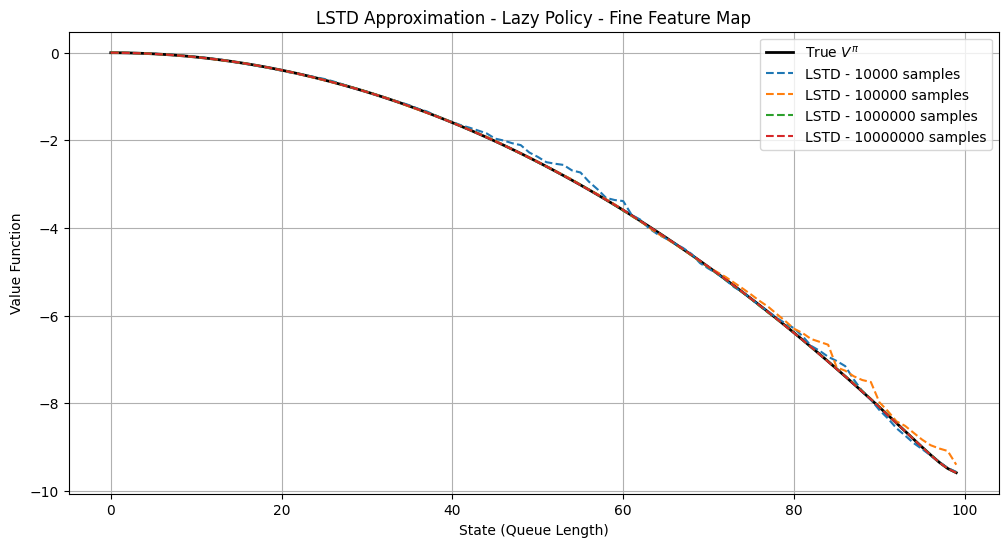

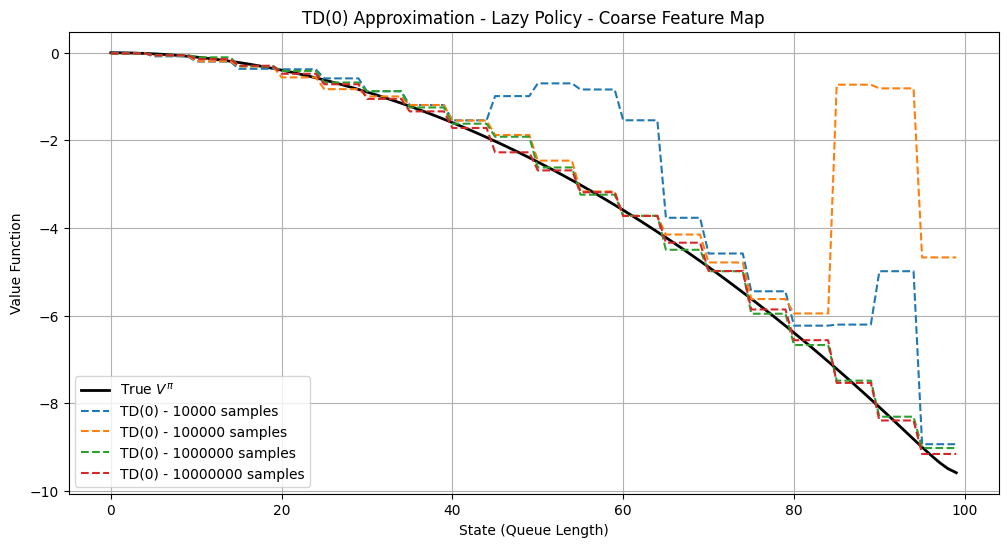

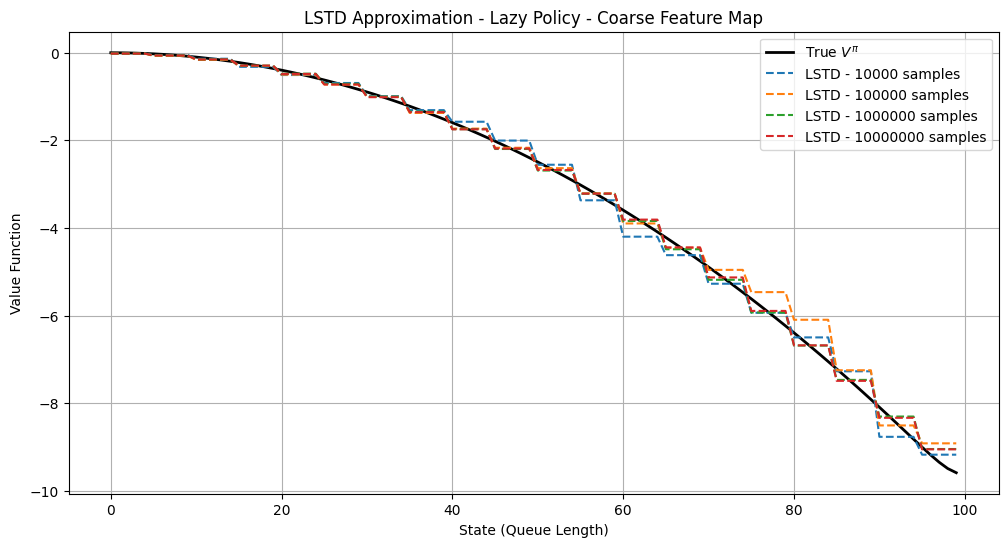

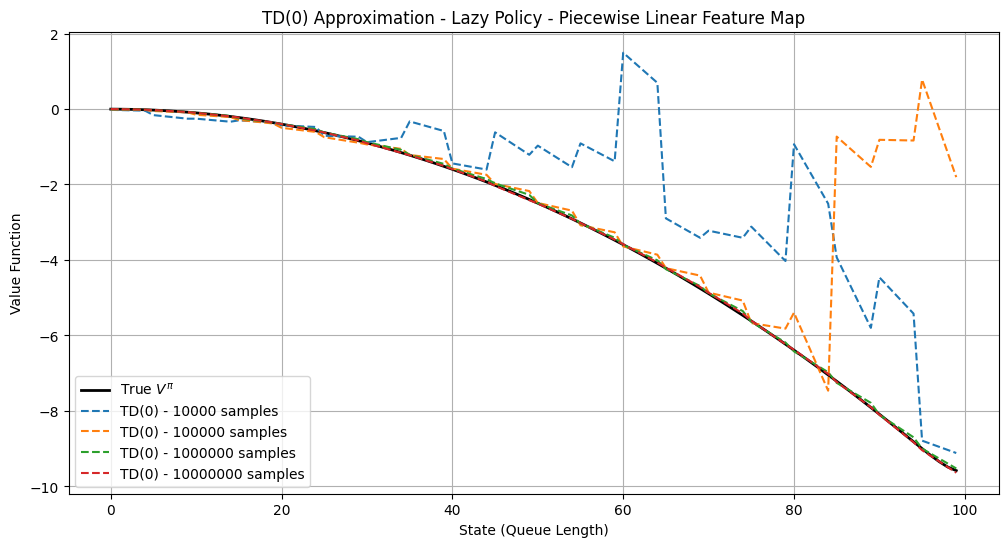

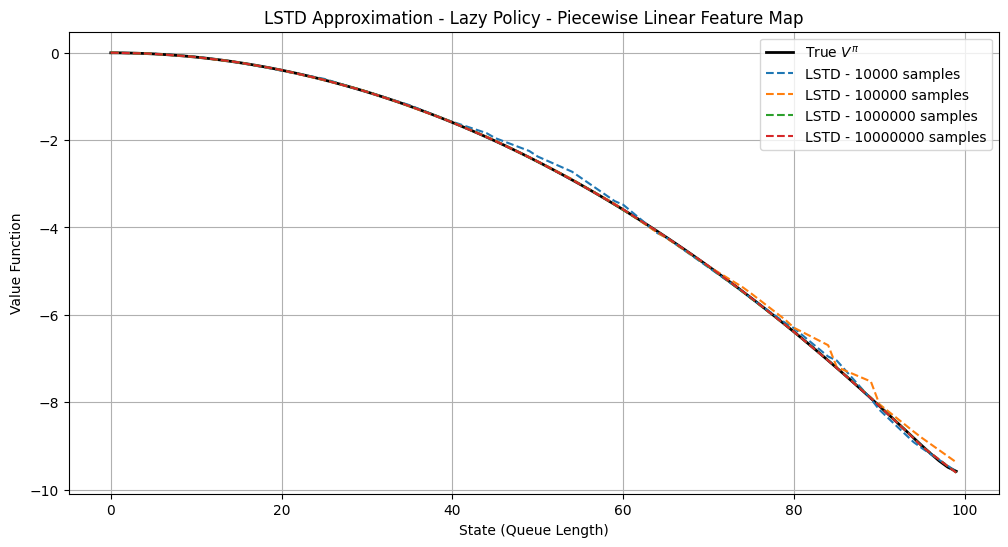

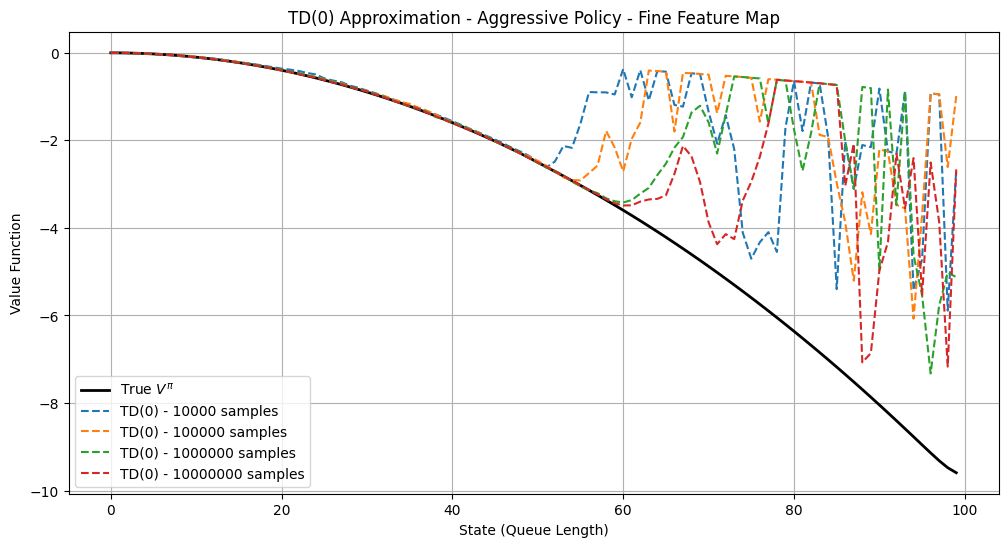

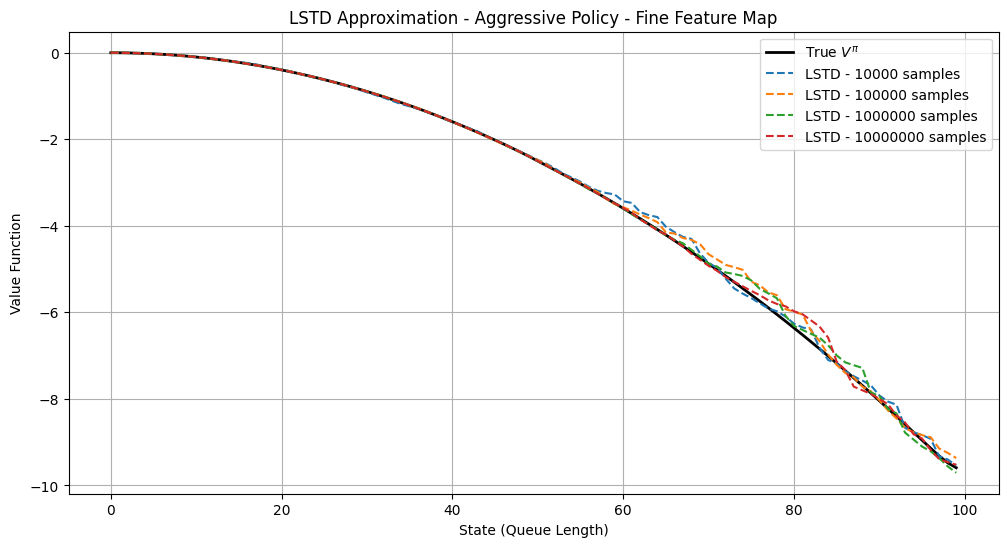

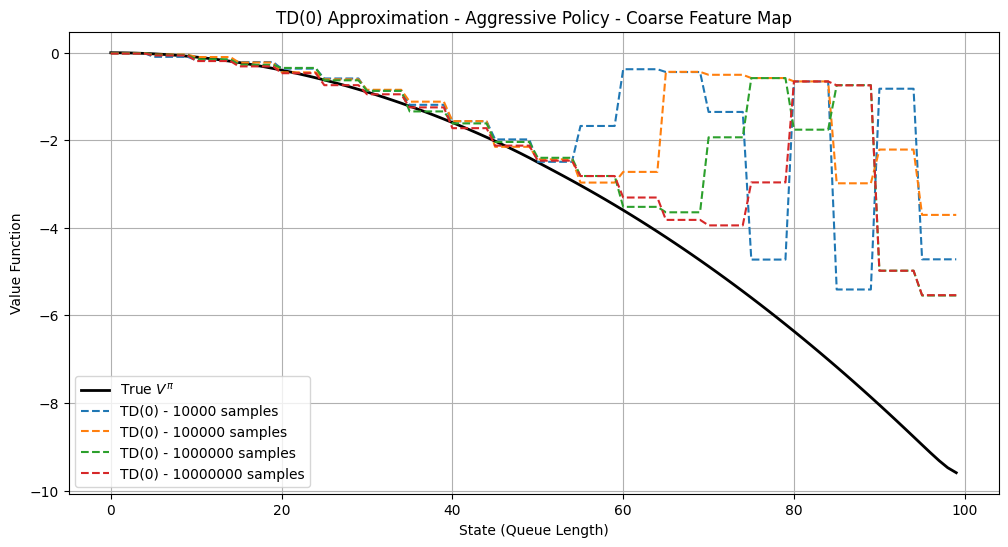

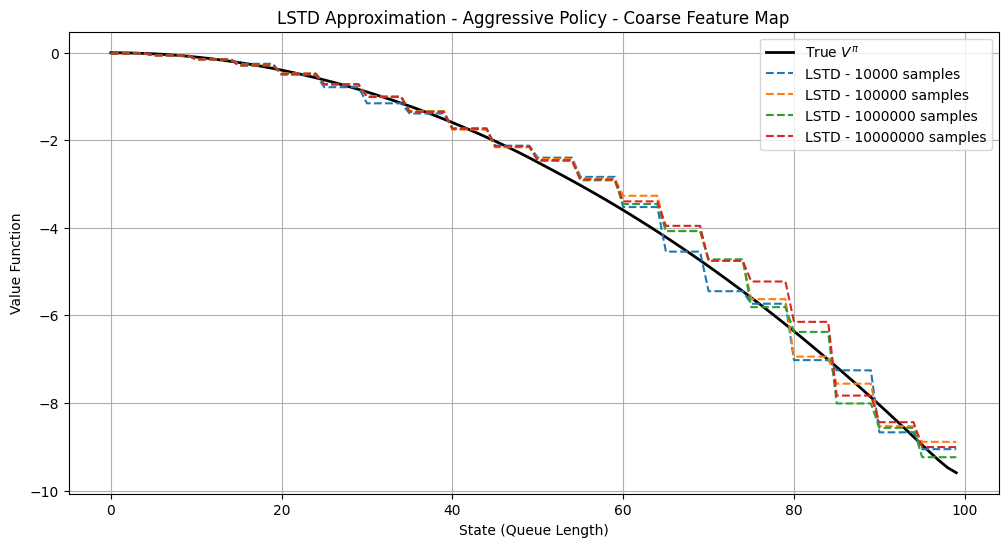

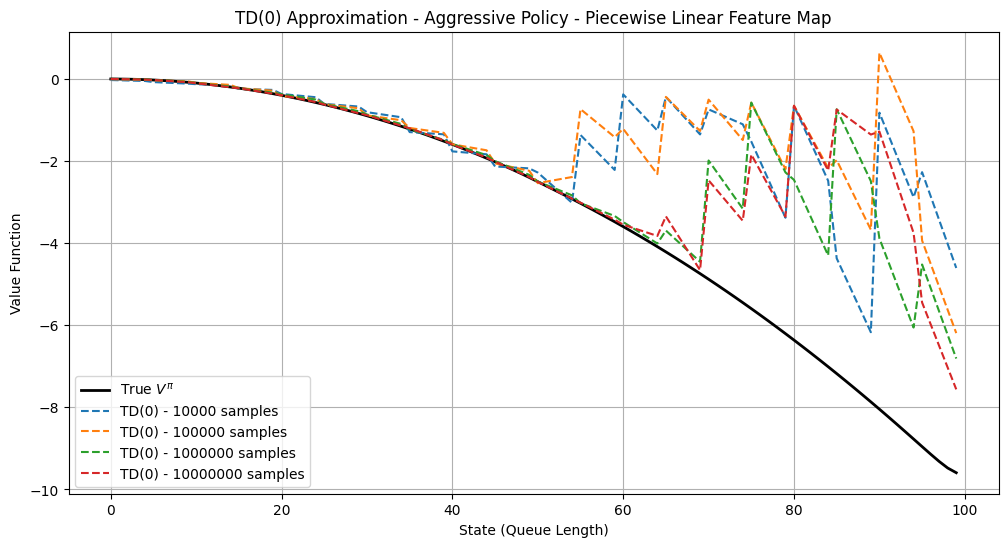

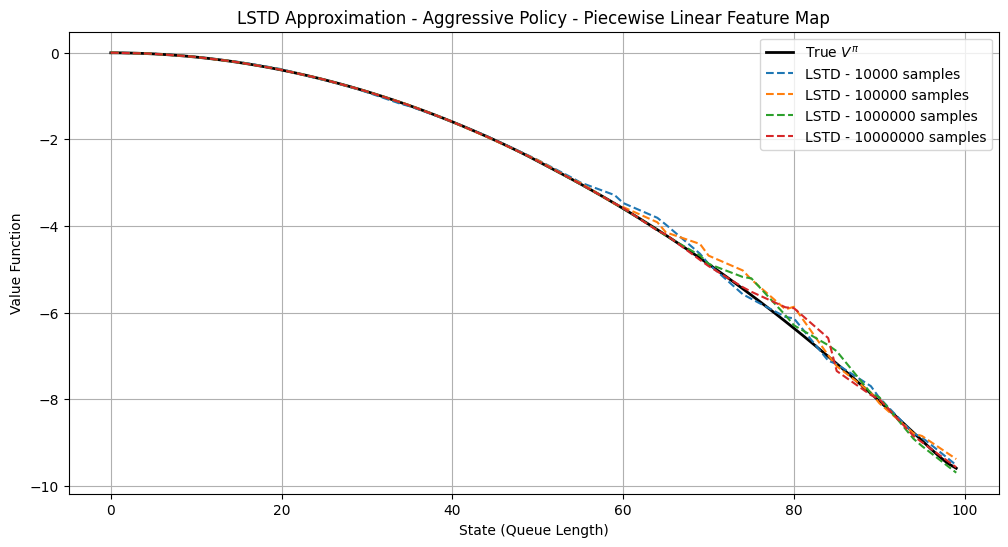

In [20]:
for policy_name, policy_data in results.items():
    V_true = V_lazy if policy_name == 'Lazy' else V_aggr
    for fm_name, fm_data in policy_data.items():
        
        # TD(0) Plot
        plt.figure(figsize=(12, 6))
        plt.plot(range(N), V_true, label='True $V^{\pi}$', color='black', linewidth=2)
        for size in sample_sizes:
            V_approx = fm_data['TD(0)'][size]
            plt.plot(range(N), V_approx, label=f'TD(0) - {size} samples', linestyle='--')
        plt.xlabel('State (Queue Length)')
        plt.ylabel('Value Function')
        plt.title(f'TD(0) Approximation - {policy_name} Policy - {fm_name} Feature Map')
        plt.legend()
        plt.grid(True)
        plt.show()

        # LSTD Plot
        plt.figure(figsize=(12, 6))
        plt.plot(range(N), V_true, label='True $V^{\pi}$', color='black', linewidth=2)
        for size in sample_sizes:
            V_approx = fm_data['LSTD'][size]
            plt.plot(range(N), V_approx, label=f'LSTD - {size} samples', linestyle='--')
        plt.xlabel('State (Queue Length)')
        plt.ylabel('Value Function')
        plt.title(f'LSTD Approximation - {policy_name} Policy - {fm_name} Feature Map')
        plt.legend()
        plt.grid(True)
        plt.show()

## d. Interpretation

We use the MSE to assess how accurate are the estimates:

$$
\text{MSE} = \frac{1}{N} \sum_{x=0}^{N-1} \left(V^\pi(x) - \hat{V}(x)\right)^2
$$

In [48]:
def mse(V_est, V_true):
    return np.mean((V_est - V_true)**2)

summary_data = []

for policy_name, policy_data in results.items():
    V_true = V_lazy if policy_name == 'Lazy' else V_aggr
    for fm_name, fm_results in policy_data.items():
        for algo in ['TD(0)', 'LSTD']:
            for size in sample_sizes:
                V_est = fm_results[algo][size]
                error = mse(V_est, V_true)
                summary_data.append({
                    'Policy': policy_name,
                    'Feature Map': fm_name,
                    'Method': algo,
                    'Samples': size,
                    'MSE': round(error, 6)
                })

df_summary = pd.DataFrame(summary_data)
df_summary = df_summary.sort_values(by=['Policy', 'Feature Map', 'Method', 'Samples'])

display(df_summary)

,Policy,Feature Map,Method,Samples,MSE
36,Aggressive,Coarse,LSTD,10000,0.066081
37,Aggressive,Coarse,LSTD,100000,0.085277
38,Aggressive,Coarse,LSTD,1000000,0.077304
39,Aggressive,Coarse,LSTD,10000000,0.112494
32,Aggressive,Coarse,TD(0),10000,8.325298
33,Aggressive,Coarse,TD(0),100000,9.739046
34,Aggressive,Coarse,TD(0),1000000,6.817211
35,Aggressive,Coarse,TD(0),10000000,5.980949
28,Aggressive,Fine,LSTD,10000,0.009677
29,Aggressive,Fine,LSTD,100000,0.021079


#### Observations

TD(0) underperforms LSTD for all feature maps, especially when sample sizes are small. This is expected since TD(0) updates incrementally and is more sensitive to variance.

Regarding encoding strategies:
- FINE feature maps $\to$ the best approximations of the true value function.
- PWL feature maps $\to$ performs well but slightly below fine encoding.
- COARSE feature maps $\to$ worst approximation across all settings, indicating insufficient complexity to capture key variations.

Thus, LSTD demonstrated superior sample efficiency and robustness, especially when paired with fine encoding, highlighting the role of evaluation methods to approximate value functions.

# 3) Compare Encoding Strategies - Learn Optimal Policy with LSTD across all Feature Maps

## a. Utilities

Helper function to convert policy matrix to callable:

In [75]:
def policy_matrix_to_fn(pi):
    """
    Converts a policy matrix pi[x, a] to a callable function that returns the action for a given state.
    """
    def policy_fn(state):
        return np.argmax(pi[state])
    return policy_fn

We update the initial sample_transitions function to handle policy matrix directly. Indeed, `sample_transitions` simulates experience by generating a sequence of transitions from the MDP, following a given policy and starting from an initial state. Earlier, we used it once per policy to generate a fixed batch of samples (reused by both TD(0) and LSTD to approximate value functions), but here the policy evolves through approximate policy iteration. As such, the function is called at every iteration, generating fresh samples from the current policy — integrating it to the learning loop.

- Comparing Evaluation Methods $\to$ fixed policy = one-time sampling 
- Comparing Feature Maps $\to$ changing policy = resample every iteration

In [76]:
def sample_transitions(pi, num_samples, initial_state=N-1):
    """
    Sample transitions (state, action, reward, next_state) following the policy matrix pi.
    """
    transitions = []
    state = initial_state
    for _ in range(num_samples):
        action = np.argmax(pi[state])  # 0: a_low, 1: a_high
        q = q_low if action == 0 else q_high
        # Sample I_t (arrival) and S_t (service)
        I_t = 1 if np.random.rand() < p else 0
        S_t = 1 if np.random.rand() < q else 0
        next_state = max(0, min(N-1, state + I_t - S_t))  # Apply trunc
        r = reward(state, action)
        transitions.append((state, action, r, next_state))
        state = next_state
    return transitions

## b. Approximate Policy Iteration function

In [ ]:
def approximate_policy_iteration(feature_map, dim, num_iterations=100, samples_per_iter=10**5):
    """
    Implements approximate policy iteration using LSTD for policy evaluation.
    
    Parameters:
    feature_map (callable): Feature map to use (e.g., fine_feature_map)
    dim (int): Dimensionality of the feature map
    num_iterations (int): Number of iterations to run
    samples_per_iter (int): Number of samples for LSTD per iteration
    
    Returns:
    V_history (list): Value functions at specified iterations
    pi_final (np.ndarray): Final policy after all iterations
    """
    # Initial policy: lazy policy (all a_low)
    pi = create_policy_lazy()
    V_history = []
    
    for k in range(num_iterations):
        # Step 1: Policy Evaluation with LSTD
        transitions = sample_transitions(pi, samples_per_iter)
        theta = lstd(transitions, feature_map, dim)
        V_hat = compute_value_function(theta, feature_map)
        
        # Store value function at iterations 10 and 100
        if k in [9, 99]:
            V_history.append(V_hat)
        
        # Step 2: Policy Improvement
        new_pi = np.zeros((N, 2))
        for x in range(N):
            Q = np.zeros(2)  # Q(x, a) for a_low and a_high
            for a in range(2):
                q = q_low if a == 0 else q_high
                # Compute Q(x, a) as specified
                Q[a] = reward(x, a)
                if x == 0:
                    Q[a] += gamma * (1 - p) * ((1 - q) * V_hat[x] + q * V_hat[x])  # x-1 not possible
                    Q[a] += gamma * p * ((1 - q) * V_hat[x + 1] + q * V_hat[x])
                elif x == N - 1:
                    Q[a] += gamma * (1 - p) * ((1 - q) * V_hat[x] + q * V_hat[x - 1])
                    Q[a] += gamma * p * ((1 - q) * V_hat[x] + q * V_hat[x])  # x+1 not possible
                else:
                    Q[a] += gamma * (1 - p) * ((1 - q) * V_hat[x] + q * V_hat[x - 1])
                    Q[a] += gamma * p * ((1 - q) * V_hat[x + 1] + q * V_hat[x])
            best_a = np.argmax(Q)
            new_pi[x, best_a] = 1.0
        pi = new_pi
    
    return V_history, pi

## c. Execution across Feature Maps

In [ ]:
# c. Execution for all feature maps
feature_maps = [
    ('FINE', fine_feature_map, N),
    ('COARSE', coarse_feature_map, N // 5),
    ('PWL', pwl_feature_map, 2 * (N // 5))
]
V_history_all = {}
pi_final_all = {}
V_final_all = {}

for fm_name, fm, dim in feature_maps:
    V_history, pi_final = approximate_policy_iteration(fm, dim, num_iterations=100)
    V_history_all[fm_name] = V_history  # Stores [V_9, V_99]
    pi_final_all[fm_name] = pi_final
    V_final_all[fm_name] = evaluate(P, pi_final, gamma)

Export results to avoid re-running the core execution:

In [ ]:
np.savez('rl_outputs_updated.npz',
         V_exact_dp=V_exact_dp,
         pi_exact_dp=pi_exact_dp,
         V_lazy=V_lazy,
         pi_lazy=pi_lazy,
         V_aggr=V_aggr,
         pi_aggr=pi_aggr,
         V_final_all=V_final_all,
         pi_final_all=pi_final_all,
         V_history_all=V_history_all)

## d. Plotting

### (i) Plot 1 - Analysis of Iteration 9 and 99

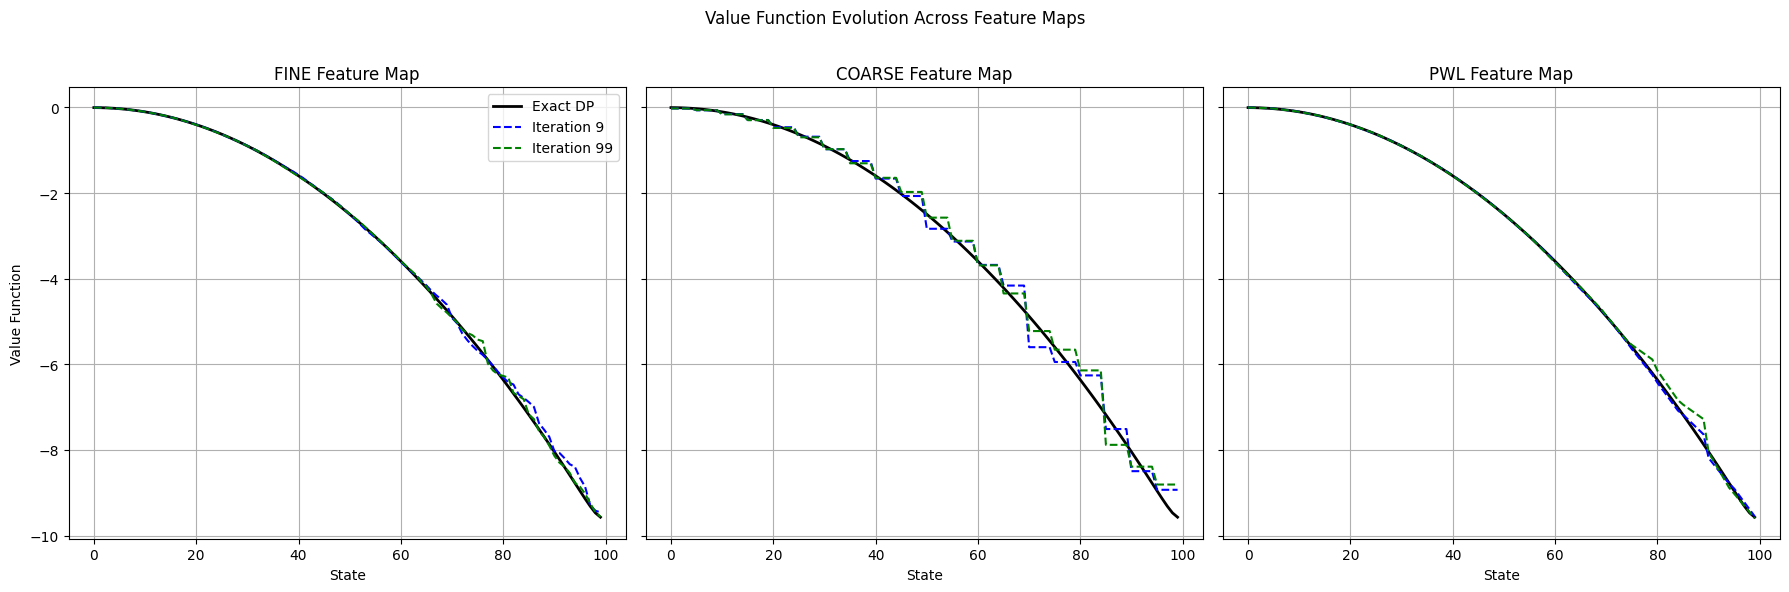

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# List of axes and corresponding feature maps
axes = [ax1, ax2, ax3]
fm_names = ['FINE', 'COARSE', 'PWL']

# Plot each feature map in its subplot
for ax, fm_name in zip(axes, fm_names):
    V_history = V_history_all[fm_name]
    ax.plot(range(N), V_exact_dp, label='Exact DP', color='black', linewidth=2)
    if len(V_history) > 0:
        ax.plot(range(N), V_history[0], label='Iteration 9', color='blue', linestyle='--')
    if len(V_history) > 1:
        ax.plot(range(N), V_history[1], label='Iteration 99', color='green', linestyle='--')
    ax.set_xlabel('State')
    ax.set_title(f'{fm_name} Feature Map')
    ax.grid(True)

# Common labels and legend
ax1.set_ylabel('Value Function')
ax1.legend()
fig.suptitle('Value Function Evolution Across Feature Maps')
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # Adjust top to fit the suptitle
plt.show()

The above subplots show the value function evolution for each feature map during Approximate Policy Iteration after 9 and 99 iterations compared to the optimal `Exact DP`.

FINE appears to converges closest, COARSE exhibits instability with larger deviations, and PWL falls in between.

### (ii) Plot 2 - Final Value Functions & Service Rates

The below plots display:
- left $\to$ the proximity of each feature map’s learned value function to the optimal value function computed in Problem 1 (Exact DP)
- right $\to$ the strategic behavior of each policy in terms of their "threshold state" (i.e the state at which they shifted from their initial service rate (lazy)), in order to compare to the optimal strategy's behaviour

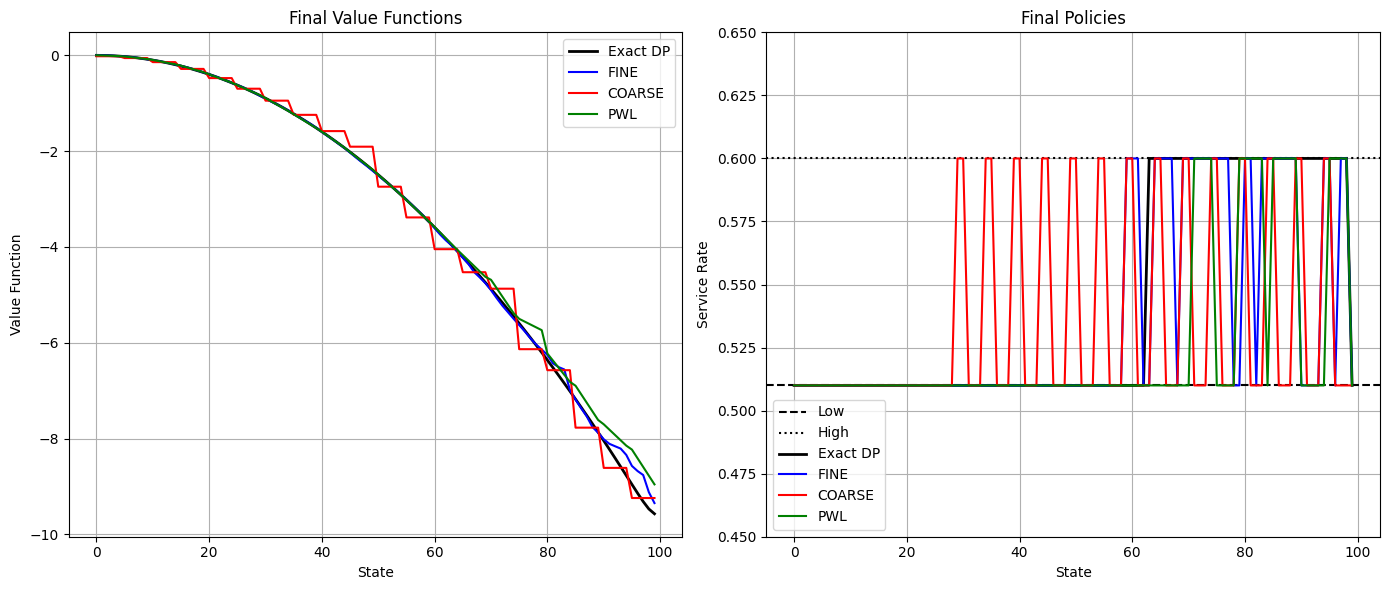

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Left plot
ax1.plot(range(N), V_exact_dp, label='Exact DP', color='black', linewidth=2) 
for fm_name, V_hat in V_final_all.items():
    color = 'red' if fm_name == 'COARSE' else 'blue' if fm_name == 'FINE' else 'green'
    ax1.plot(range(N), V_hat, label=fm_name, color=color)
ax1.set_xlabel('State')
ax1.set_ylabel('Value Function')
ax1.set_title('Final Value Functions')
ax1.legend()
ax1.grid(True)

# Right plot
ax2.axhline(y=q_low, color='black', linestyle='--', label='Low')
ax2.axhline(y=q_high, color='black', linestyle=':', label='High')
# Add Exact DP
service_rates_exact = np.zeros(N)
for x in range(N):
    a = np.argmax(pi_exact_dp[x])
    service_rates_exact[x] = q_low if a == 0 else q_high
ax2.plot(range(N), service_rates_exact, label='Exact DP', color='black', linewidth=2)
# Service rates for each feature map
for fm_name, pi in pi_final_all.items():
    service_rates = np.zeros(N)
    for x in range(N):
        a = np.argmax(pi[x])
        service_rates[x] = q_low if a == 0 else q_high
    color = 'red' if fm_name == 'COARSE' else 'blue' if fm_name == 'FINE' else 'green'
    ax2.plot(range(N), service_rates, label=fm_name, color=color)
ax2.set_xlabel('State')
ax2.set_ylabel('Service Rate')
ax2.set_title('Final Policies')
ax2.legend()
ax2.grid(True)
ax2.set_ylim([0.45, 0.65])  # Adjusted to zoom in

plt.tight_layout()
plt.show()

The left plot shows:
- Fine feature appears as the closest to the optimal value function
- Coarse feature is the most unstable learning method

The right plot shows:
- Earliest use of high service rate $\to$ Coarse feature
- Latest use of high service rate $\to$ PWL feature

### (ii) Plot 3 - Explicit Strategies

The below plot intends to better display the shift of strategy accross policies, since the previous right subplot overlaps them.

**Note:** the `average service rate` should not be interpreted as a meaningful indicator of proximity with the optimal policy "Exact DP". It has been computed for practical purpose (i.e. having a structure to position the policies on the y-axis of such a plot), since this value is not very informative of the policy it arises from. Indeed, the mean of the "service_rates" variable accross all states simply depends on the number of time a policy selects the aggressive action, which mean that it does not include its distribution accross states. so not reflecting the good or bad use of aggressive action when the value function benefits more (i.e. higher queue lenght with larger penalties).

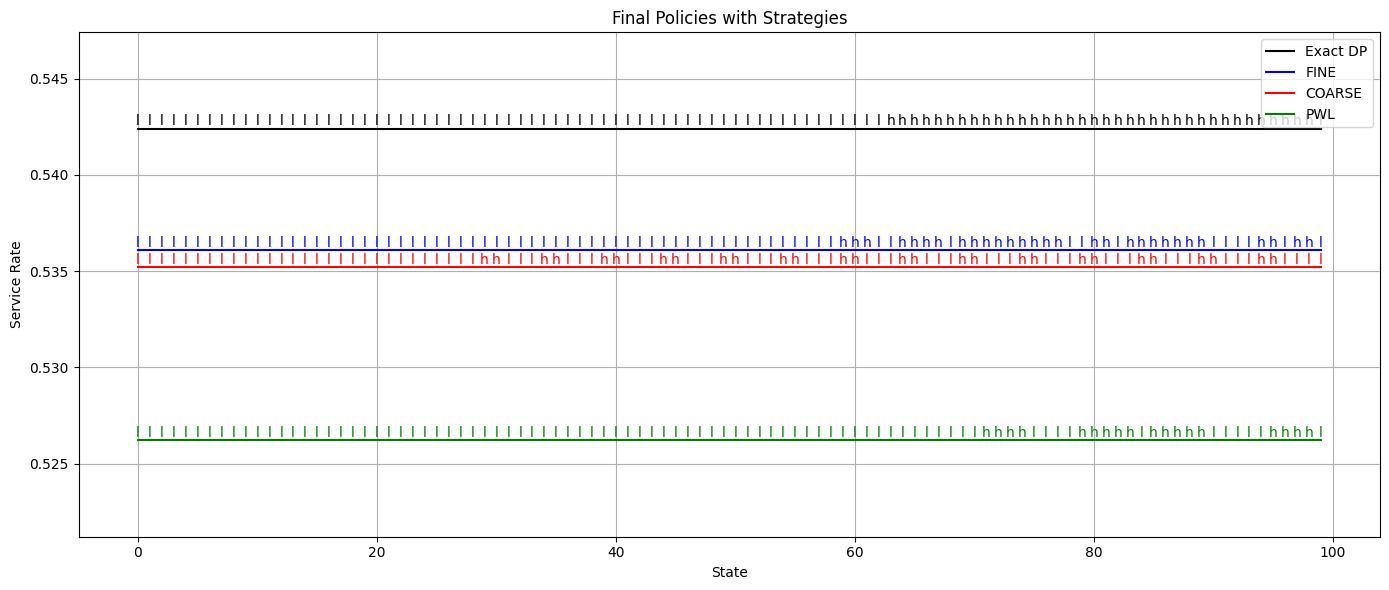

In [ ]:
fig, ax2 = plt.subplots(figsize=(14, 6))

# Compute service rates and their averages
policies = {
    'Exact DP': pi_exact_dp,
    'FINE': pi_final_all['FINE'],
    'COARSE': pi_final_all['COARSE'],
    'PWL': pi_final_all['PWL']
}
avg_service_rates = {}
service_rates_dict = {}

for name, pi in policies.items():
    service_rates = np.zeros(N)
    for x in range(N):
        a = np.argmax(pi[x])
        service_rates[x] = q_low if a == 0 else q_high
    service_rates_dict[name] = service_rates
    avg_service_rates[name] = np.mean(service_rates)

colors = {
    'Exact DP': 'black',
    'FINE': 'blue',
    'COARSE': 'red',
    'PWL': 'green'
}

# Plot each policy at its average service rate
for idx, (name, avg_rate) in enumerate(avg_service_rates.items()):
    # Plot the solid line at the average service rate
    ax2.plot(range(N), [avg_rate] * N, color=colors[name], label=name)
    # Place letters just above the line, as if underlined
    for x in range(N):
        rate = service_rates_dict[name][x]
        ax2.text(x, avg_rate + 0.00001, 'l' if rate == q_low else 'h', 
                 color=colors[name], ha='center', va='bottom')


ax2.set_xlabel('State')
ax2.set_ylabel('Service Rate')
ax2.set_title('Final Policies with Strategies')
ax2.legend(loc='upper right')
ax2.grid(True)
ax2.set_ylim([min(avg_service_rates.values()) - 0.005, max(avg_service_rates.values()) + 0.005])

plt.tight_layout()
plt.show()

# 4) Conclusion

This table summarizes the policies evaluated in this notebook along two main axes: the cutoff state, which serves as a proxy for the aggressiveness threshold, and the proportion of high-service actions selected across the state space. The optimal policy serves as the reference.

In [ ]:
def get_cutoff_index(pi, q_threshold=q_low):
    """
    Returns the first state where the policy switches to aggressive (high service rate).
    """
    for x in range(N):
        if np.argmax(pi[x]) == 1:  # a_high
            return x
    return None  # never switches

def high_service_ratio(pi):
    """
    Percentage of states where policy chooses high service (a_high).
    """
    return np.mean([np.argmax(pi[x]) == 1 for x in range(N)])

In [56]:
# Collect data
policies = {
    'Optimal (HW1)': pi_exact_dp,
    'API + Fine': pi_final_all['FINE'],
    'API + Coarse': pi_final_all['COARSE'],
    'API + PWL': pi_final_all['PWL']
}

summary = []
opt_cutoff = get_cutoff_index(pi_exact_dp)

for name, pi in policies.items():
    cutoff = get_cutoff_index(pi)
    high_ratio = high_service_ratio(pi)
    diff = cutoff - opt_cutoff if cutoff is not None else None
    
    if name == 'Optimal (HW1)':
        label = 'Theoretical benchmark'
    elif diff == 0:
        label = 'Exactly optimal!'
    elif abs(diff) <= 5:
        label = 'Near-optimal'
    else:
        label = 'Limited by features'
    
    summary.append((name, cutoff, diff, f"{100 * high_ratio:.1f}%", label))

# Print formatted table
print(f"{'Method':<22}{'Cutoff':>8}{'Δ vs Opt':>10}{'High %':>10}{'Assessment':>25}")
print("-" * 75)
for row in summary:
    print(f"{row[0]:<22}{row[1]:>8}{row[2]:>10}{row[3]:>10}{row[4]:>25}")

Method                  Cutoff  Δ vs Opt    High %               Assessment
---------------------------------------------------------------------------
Optimal (HW1)               63         0     36.0%    Theoretical benchmark
API + Fine                  59        -4     29.0%             Near-optimal
API + Coarse                29       -34     28.0%      Limited by features
API + PWL                   71         8     18.0%      Limited by features


#### Observations

To compare policies, two metrics are particularly useful:

- Cutoff $\to$ state at which the policy switches from using initial (low-cost) action to the aggressive one, reflecting the policy’s responsiveness to rising queue lengths.
  
- Δ vs Opt $\to$ difference between a policy's cutoff point and the one of the optimal policy. Negative values imply the policy switches too early, and positive values indicate overly conservative behavior.

- High % $\to$ percentage of states where the policy chooses the aggressive action, serves as a rough proxy for the cost-efficiency tradeoff adopted by the policy.

---

From the table:

- Optimal Policy $\to$ cutoff at state 63, meaning it waits until the queue is significantly long before acting aggressively, and choosing aggressive actions 36% of the time.
- API + Fine $\to$ comes closest to optimal, with a cutoff just 4 states earlier and a relatively similar action distribution (29%).
- API + Coarse and API + PWL $\to$ significantly diverge, the Coarse version switches too early (cutoff 29), and PWL too late (cutoff 71). Both policies spread aggressive actions less meaningfully — either too uniformly or too erratically (maybe due to loss of resolution in the state representation).

## Conclusion

While Approximate Policy Iteration (API) methods succeed in capturing the overall shape of the optimal strategy $\to$ performance remains limited by the chosen feature maps. As showed by both plots and table, the **coarse feature is the most unstable way to represent the queu lenght for the learning**, while the **fine feature captures the structure of the value function fairly well due to its one-hot state representation**, with more data and computation we would probably reduce the difference with the optimal.

## Reloading Previously Exported Results

In [3]:
# To reload
data = np.load('rl_outputs_updated.npz', allow_pickle=True)

V_exact_dp = data['V_exact_dp']
pi_exact_dp = data['pi_exact_dp']
V_lazy = data['V_lazy']
pi_lazy = data['pi_lazy']
V_aggr = data['V_aggr']
pi_aggr = data['pi_aggr']
V_final_all = data['V_final_all'].item()
pi_final_all = data['pi_final_all'].item()
V_history_all = data['V_history_all'].item()